In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
import numpy as np
np.set_printoptions(legacy='1.25')
import os
import warnings
from functions import *
import ast
warnings.filterwarnings('ignore', category=FutureWarning)

# Poshmark Data Analytics: EDA

This project aims to explore what's selling on Poshmark, sell-through rates for specific products, and the best brands and products to source for resellers on Poshmark. Data was ethically sourced through web-scraping on Poshmark with a script that follows the site's scraping guidlines outlined in the **Robots.txt** file.

The data contains information about sold listings on Poshmark. I chose a few popular categories to scrape and do analyses on instead of selecting from all sold listings on Poshmark, as I wanted to focus on Women's clothing and exclude home and makeup items from the analysis. The categories are: tops, dresses, bags, jeans and skirts.

*For privacy protection, my scraping script is located in a separate directory, and I will remove usernames and the links to specific products from the dataframes before analyses; these columns were used as primary keys to identify unique listings but are not necessary for the data analysis.*

## 1. Opening the Files

In [2]:
tops = pd.read_csv(os.path.expanduser('~/Desktop/data/listings-tops.csv'))
skirts = pd.read_csv(os.path.expanduser('~/Desktop/data/listings-skirts.csv'))
jeans = pd.read_csv(os.path.expanduser('~/Desktop/data/listings-jeans.csv'))
bags = pd.read_csv(os.path.expanduser('~/Desktop/data/listings-bags.csv'))
dresses = pd.read_csv(os.path.expanduser('~/Desktop/data/listings-dresses.csv'))

dfs = [tops, skirts, jeans, bags, dresses]

In [3]:
for df in dfs:
    df.drop(columns = ['link','user'], inplace=True)

In [4]:
tops.columns

Index(['name', 'sold price', 'original price', 'post_date', 'size', 'brand',
       'categories', 'color(s)', 'sold date', 'nwt', 'boutique'],
      dtype='object')

## 2. Data Description

Columns:

1. **name**: The name of the listing as it appears on the listing's title.

2. **sold price**: The price the item sold for on Poshmark.

3. **original price**: The price the seller indicated was the original retail price of the item. 
    -- *Limitations:* This information may be inaccurate as it is user-provided, and some listings do not specify an original price.

4. **post_date**: The date the listing was sold to a buyer.

5. **size**: Size of the garmet if applicable.

6. **brand**: Brand of the garmet if applicable.

7. **categories**: Categories of the item.

8. **color(s)**: Colors of the item as outlined in the name. 
    -- *Limitations:* The color is only added to this list if there are mentions of a color in the name.

9. **sold_date**: The inferred sold date of the listing.
    -- *Limitations:* The sold date is inferred based on when the listing was added to the recently sold items page.

10. **nwt**: Whether an item is "New with Tags". 

11. **boutique**: Whether an item was sold from a Boutique, which is a shop that resells clothing sourced from wholesalers rather than used clothing or clothing sourced elsewhere.

## 3. Data Cleaning

*Cleaning Tasks:*
* Convert numeric columns to correct datatypes.
* Explode the color column for color analyses.
* Convert dates to datetime objects.

In [6]:
for i, df in enumerate(dfs):
    # specifying correct datatypes
    df['sold price'] = df['sold price'].str.replace(',','').str.strip('$').astype('Int64')
    df['original price'] = df['original price'].str.replace(',','').str.strip('$').astype('Int64')
    df['nwt'] = df['nwt'].astype('Int64')
    df['boutique'] = df['boutique'].astype('Int64')
    df['sold date'] = pd.to_datetime(df['sold date'], format='%m-%d-%Y', errors='coerce')
    df['post_date'] = pd.to_datetime(df['post_date'], format='%Y-%m-%d', errors='coerce')

    # adding a column indicating how long a listing took to sell
    df['days to sell'] = (df['sold date'] - df['post_date']).dt.days

    # one-hot encoding for colors
    df['color(s)'] = df['color(s)'].str.lower()
    df['color(s)']  = df['color(s)'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
    exploded = df.explode('color(s)')
    dummies = pd.get_dummies(exploded['color(s)'])
    ohe_df = dummies.groupby(exploded.index).sum()
    df = df.join(ohe_df)
    dfs[i] = df

tops, skirts, jeans, bags, dresses = dfs

In [7]:
tops

,name,sold price,original price,post_date,size,brand,categories,color(s),sold date,nwt,...,red,salmon,silver,sky blue,tan,teal,turquoise,violet,white,yellow
0,PLUS WASHED SHORT SLEEVE TOP WITH POCKETS 1 XL,15,<NA>,2025-04-26,1X,Zenana Outfitters,"['Women', 'Tops']","[green, blue]",2025-05-28,0,...,0,0,0,0,0,0,0,0,0,0
1,Reformation Hattie Linen Top Rosin,115,148,2025-05-17,6,Reformation,"['Women', 'Tops']","[white, pink]",2025-05-28,0,...,0,0,0,0,0,0,0,0,1,0
2,Savanna Jane Blue Boho Embroidered Flowy Summe...,48,58,2025-04-20,1X,Savanna Jane,"['Women', 'Tops']","[blue, purple]",2025-05-28,0,...,0,0,0,0,0,0,0,0,0,0
3,Final price ✨NWT Free People crop,55,128,2023-01-30,S,Free People,"['Women', 'Tops']",[],2025-05-28,1,...,0,0,0,0,0,0,0,0,0,0
4,Pedigree ButterSoft Baby Tee Crop Top | Black,18,28,2025-05-15,M,Pedigree Sportswear,"['Women', 'Tops']",[black],2025-05-28,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25709,Jaded Gypsy Royal Garden Top..Tea Stain color.,108,168,2024-10-19,XL,Jaded Gypsy,['tops'],[],2025-06-10,0,...,0,0,0,0,0,0,0,0,0,0
25710,Sun & Moon Mesh Abbreviated Top,20,<NA>,2019-09-15,S,NaN,['tops'],[],2025-06-10,0,...,0,0,0,0,0,0,0,0,0,0
25711,Indigo Thread Co Denim & Lace Top,59,60,2025-06-04,XL,NaN,['tops'],[indigo],2025-06-10,0,...,0,0,0,0,0,0,0,0,0,0
25712,Fp Movement By Free People Hot Shot Hooded Lay...,60,60,2025-06-05,XS,NaN,['tops'],[],2025-06-10,1,...,0,0,0,0,0,0,0,0,0,0


## 4. Top Performing Brands by Volume of Sales

Identifying the top-performing brands based on popularity.

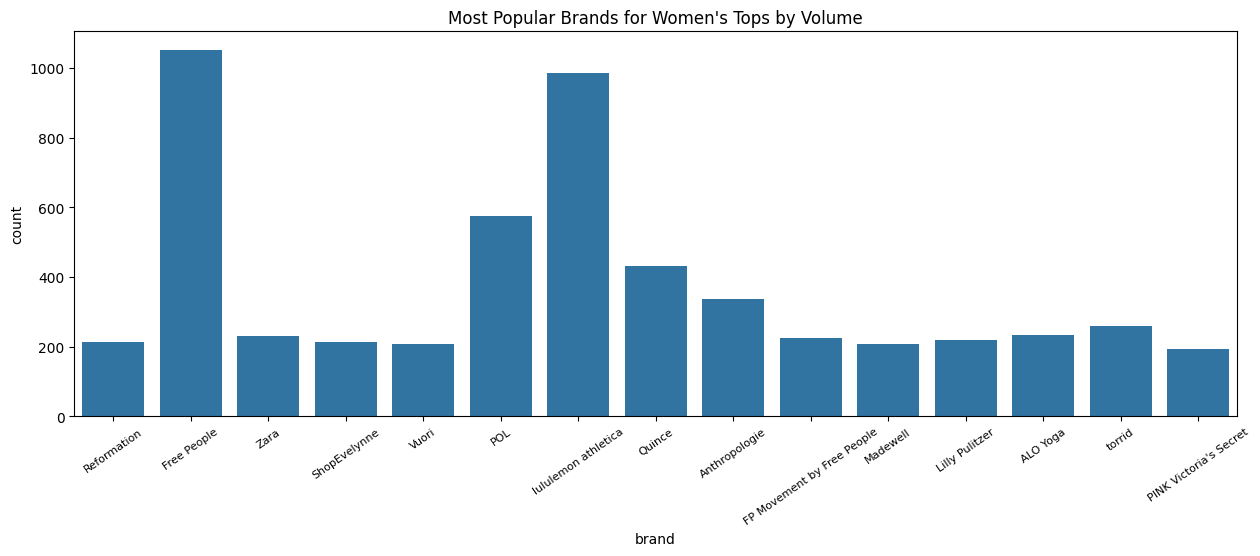

In [8]:
# top 10 brands for tops by number of sold listings
top_brands = tops['brand'].value_counts().head(15).index
popular_brand_df = tops[tops['brand'].isin(top_brands)]

plt.figure(figsize=(15,5))
plt.xticks(rotation=35, fontsize=8)
plt.title("Most Popular Brands for Women's Tops by Volume")

ax = sns.countplot(data=popular_brand_df, x='brand')

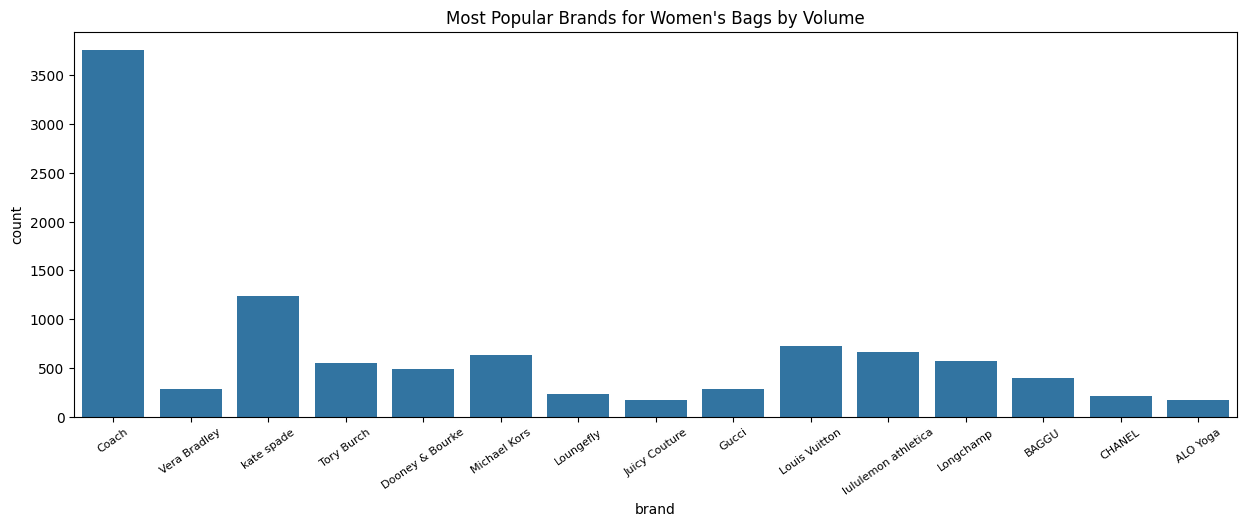

In [9]:
# top 10 brands for bags by number of sold listings
top_brands_bags = bags['brand'].value_counts().head(15).index
popular_brand_bags_df = bags[bags['brand'].isin(top_brands_bags)]

plt.figure(figsize=(15,5))
plt.xticks(rotation=35, fontsize=8)
plt.title("Most Popular Brands for Women's Bags by Volume")

ax = sns.countplot(data=popular_brand_bags_df, x='brand')

## 5. Brands with Quickest Sell-through Rate

Identifying the brands that sell the fastest, on average.

In [11]:
def avg_days_to_sell_by_brand(df, num_brands, min_sales, category):    
    
    brand_counts = df['brand'].value_counts()
    brands_over_min_sales = brand_counts[brand_counts > min_sales].index

    tops_filtered = tops[tops['brand'].isin(brands_over_min_sales)].sort_values(by='days to sell', ascending=True)

    fastest_brands = tops_filtered.groupby('brand')['days to sell'].agg('mean').sort_values(ascending=True).reset_index()

    top_fastest = fastest_brands[:num_brands]

    plt.figure(figsize=(15, 6))
    sns.barplot(data=top_fastest, x='days to sell', y='brand', palette='viridis')

    plt.title(f"Top {num_brands} Brands with Lowest Average Days to Sell in Women's {category} (Brands with >{min_sales} Listings)")
    plt.xlabel('Average Days to Sell')
    plt.xticks(fontsize=9)
    plt.ylabel('Brand')

    plt.tight_layout()
    plt.show()


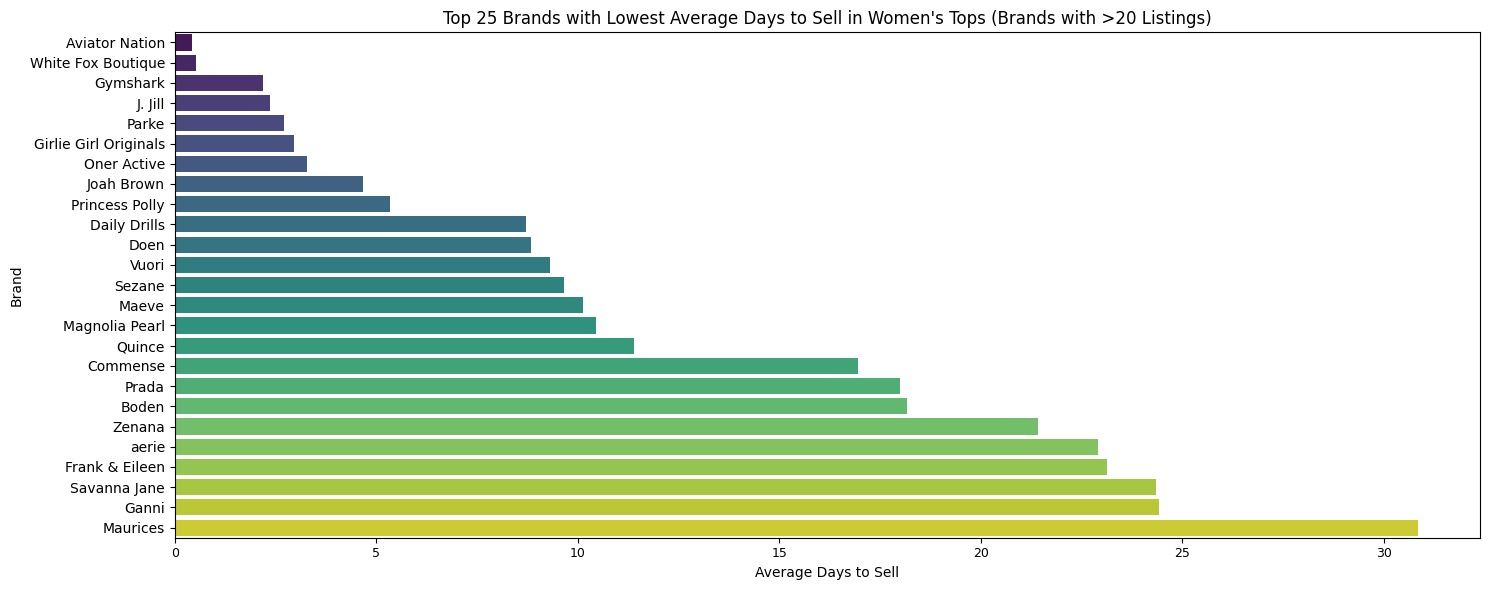

In [12]:
avg_days_to_sell_by_brand(tops, 25, 20, 'Tops')

#### *Removing Outliers*

Some top-selling brands, such as *Free People* and *lululemon*, is not included in the quickest days to sell. There may be some extreme outliers in the 'days to sell' column, which should be removed for a better visualization.

Text(0.5, 1.0, 'Days to sell Free People tops')

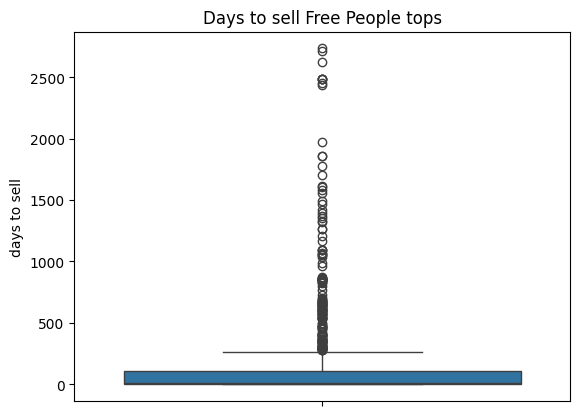

In [13]:
# visualizing the outliers for Free People
sns.boxplot(tops[tops['brand'] == 'Free People']['days to sell'])
plt.title("Days to sell Free People tops")

Based on the boxplot, the tail of outliers going into the 1000+ days to sell range may be weighing down the average.

Text(0.5, 1.0, 'Days to sell Free People tops, outliers removed')

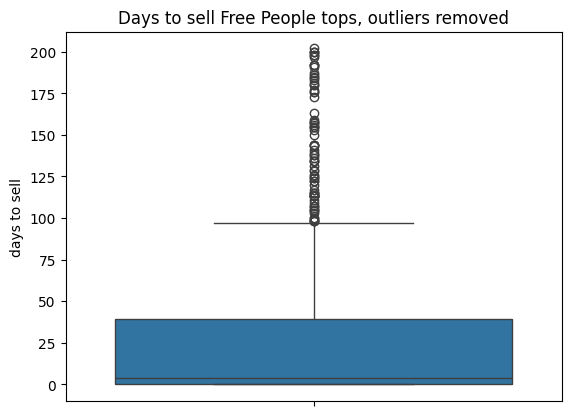

In [14]:
filtered_tops = remove_outliers_iqr(tops, 'days to sell')
sns.boxplot(filtered_tops[filtered_tops["brand"]=="Free People"]["days to sell"])
plt.title('Days to sell Free People tops, outliers removed')

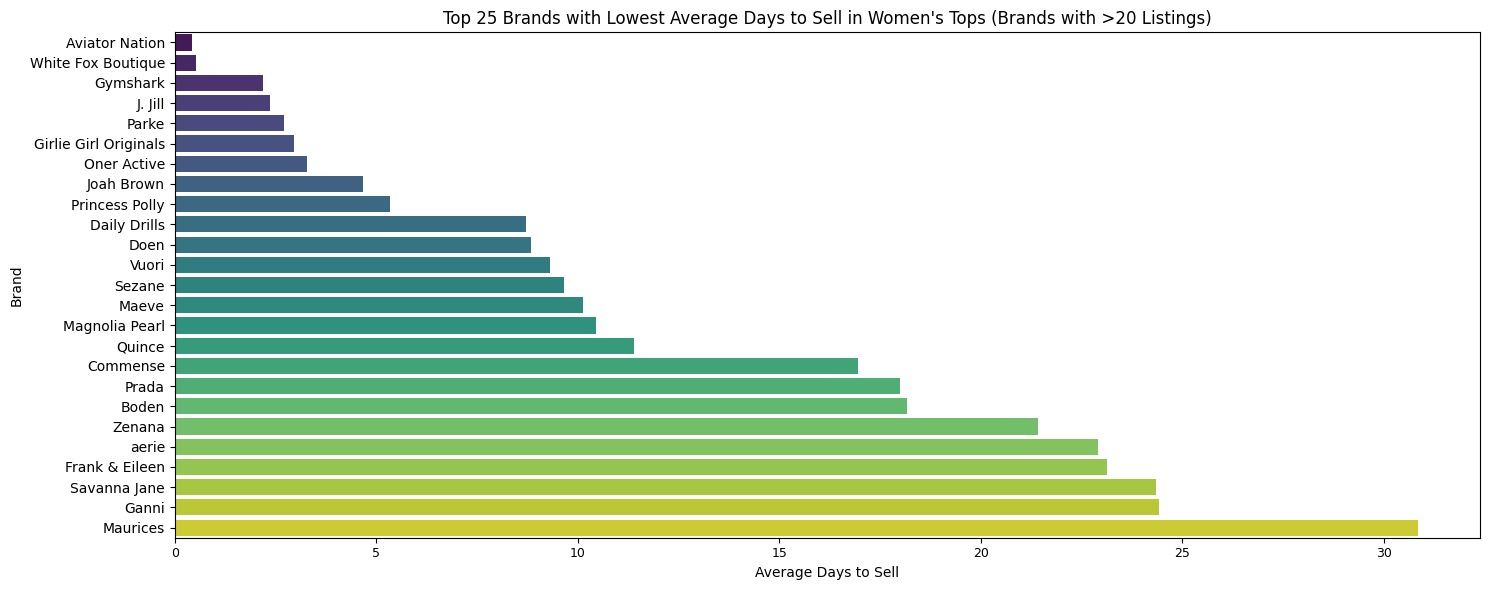

In [15]:
avg_days_to_sell_by_brand(filtered_tops, 25, 20, 'Tops')

Removing outliers via IQR did not add *Free People* to the top-selling brands, indicating *Free People* is a popularly purchased brand, but it takes longer to sell compared to other popular brands. This could be important for someone sourcing inventory for their shop, as prioritizing quick-to-sell brands may align more with their shop goals.

It also could be due brands with fewer rows taking over; next I will visualize by only including brands with more than 100 listings in the dataset.

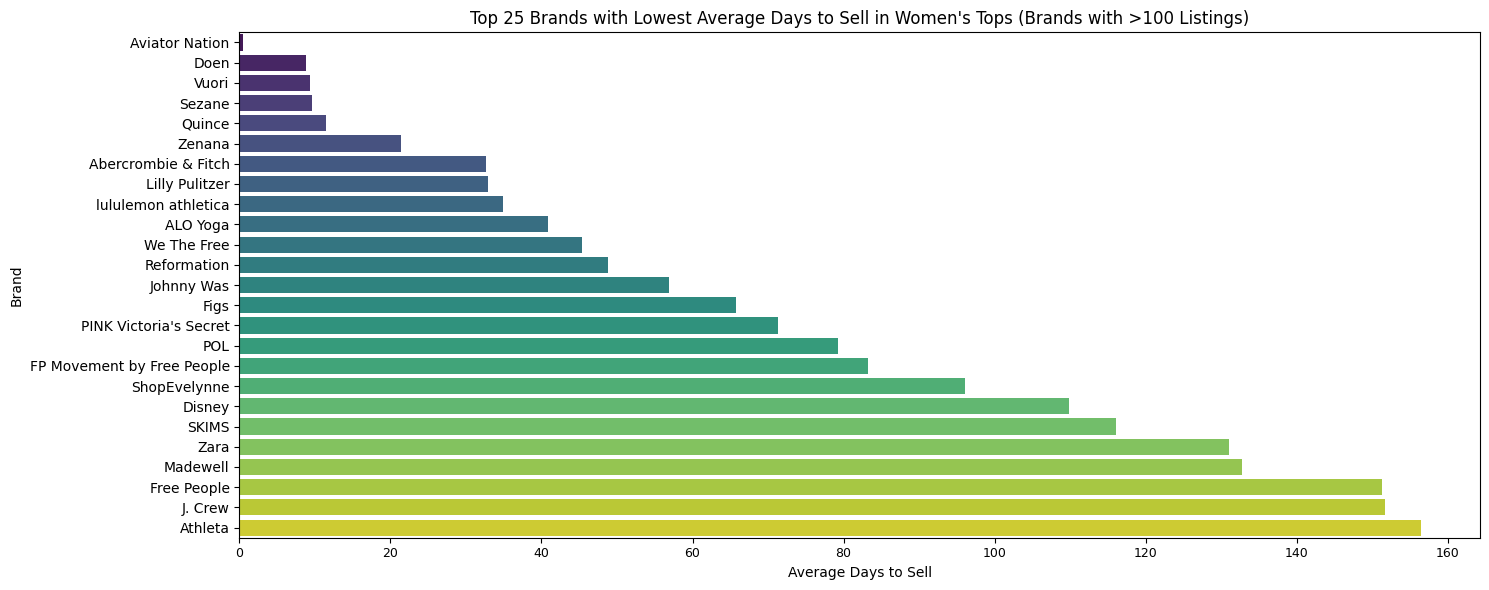

In [16]:
avg_days_to_sell_by_brand(filtered_tops, 25, 100, 'Tops')

#### Discussion

When only including brands with 100+ listings, *Free People* is still the second lowest to sell even after outliers were removed, indicating that *Free People* may be a slower-to-sell brand, on average.

This may be an important factor to resellers when sourcing items, if they have quick sales goals to meet.

### Sell-Through Rates for Other Categories

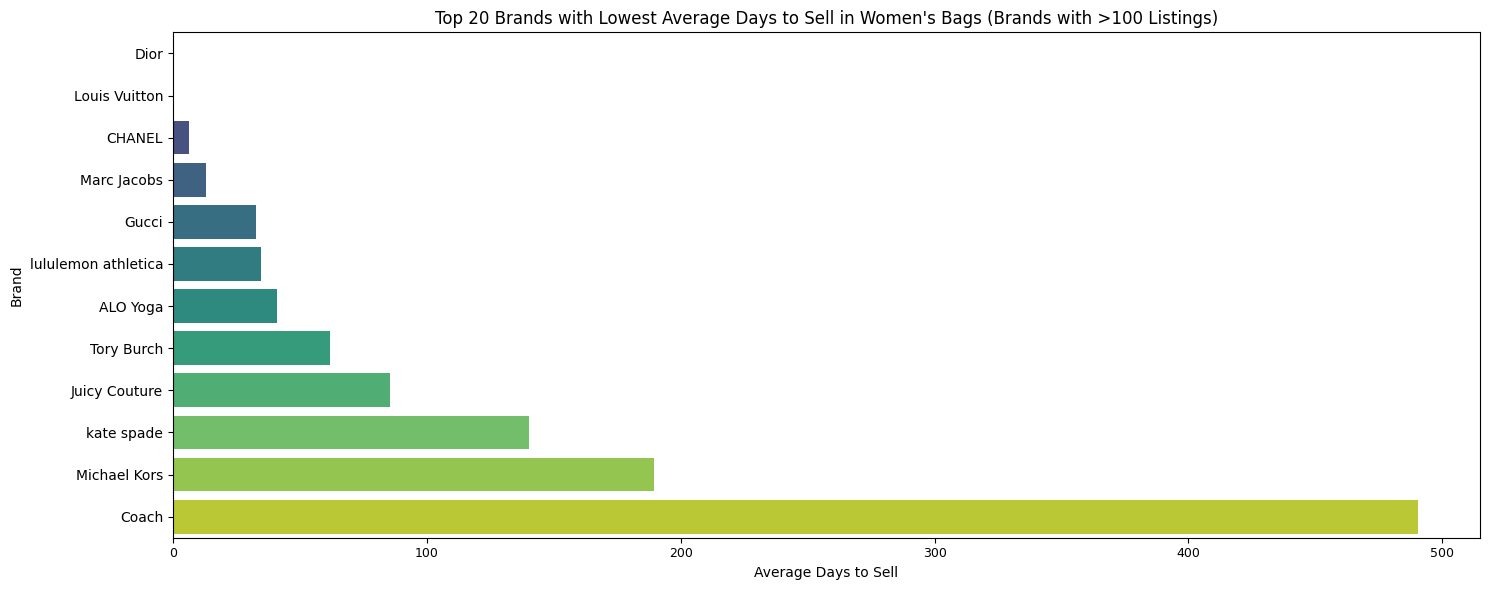

In [18]:
# bags with 100+ listings, outliers removed
avg_days_to_sell_by_brand(remove_outliers_iqr(bags, 'days to sell'), 20, 100, 'Bags')

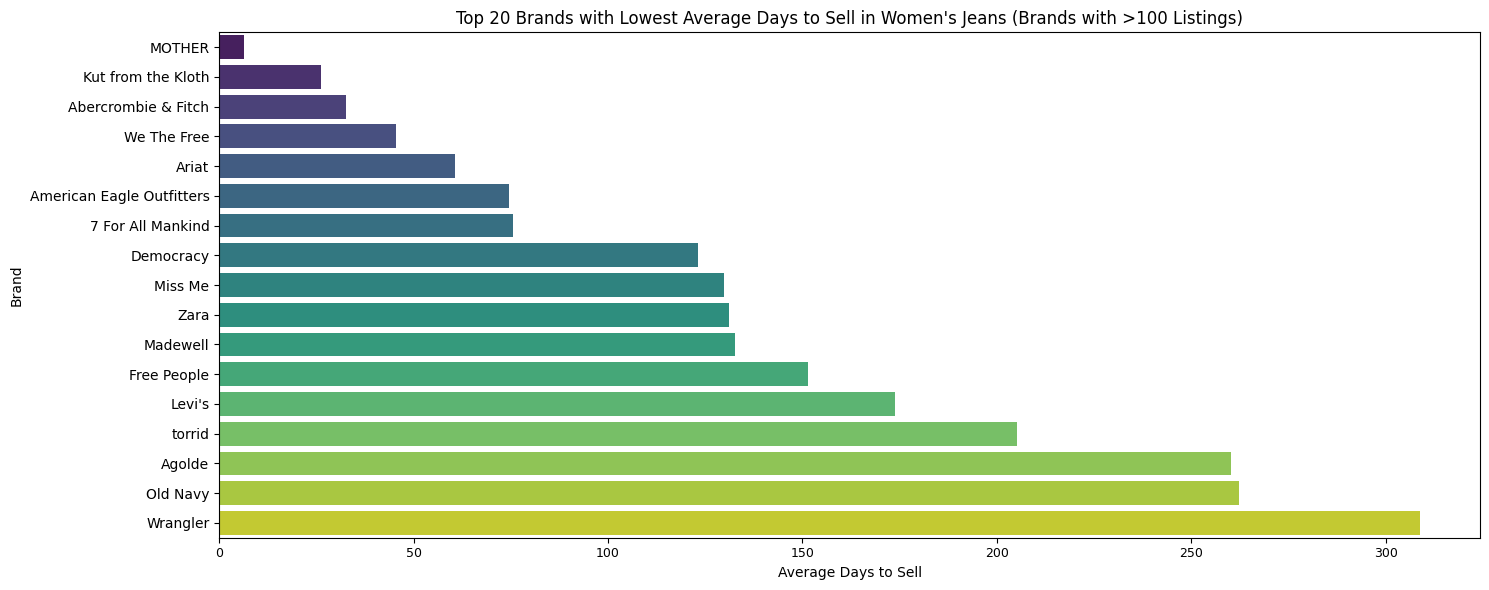

In [19]:
# jeans with 100+ listings, outliers removed
avg_days_to_sell_by_brand(remove_outliers_iqr(jeans, 'days to sell'), 20, 100, 'Jeans')

## 6. Sizing Analysis

In [20]:
size_counts = tops['size'].value_counts()[:10]
top_10_sizes = tops[tops['size'].isin(size_counts.index)]

<Axes: xlabel='size'>

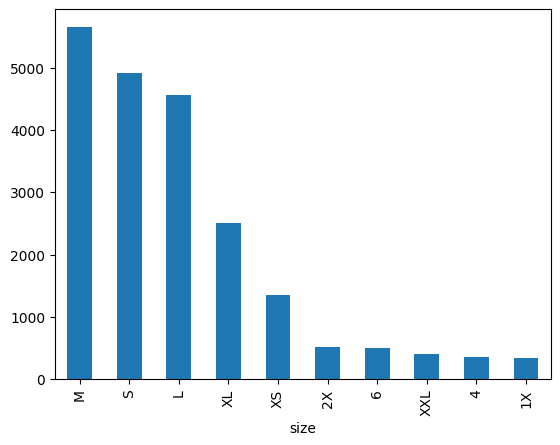

In [21]:
size_counts.plot(kind='bar')

In [22]:
# average sold price by size of item
top_10_sizes.groupby(by='size')['sold price'].agg('mean').sort_values(ascending=False)

size
4      45.512748
6      40.532129
S      38.158601
XS     36.815965
M      33.054446
L      30.869394
2X     26.814229
1X     26.468843
XL     26.287315
XXL    23.482759
Name: sold price, dtype: Float64

## 7. Average Prices by Brand

In [24]:
tops.groupby('brand')['sold price'].agg('mean')

brand
-BL^NK-                  118.0
.                    89.857143
1. State                  20.0
11 Honore                 26.0
120% Lino                 75.0
                       ...    
xenana outfitters         10.0
xoxoklowe                 64.0
yllw                      85.0
zaddy                     50.0
zeela                      5.0
Name: sold price, Length: 2206, dtype: Float64

In [24]:
# tops with at least 20 sales in the dataset
tops_at_least_20 = tops[tops['brand'].isin(tops['brand'].value_counts().head(20).index)]

In [25]:
brand_avg_prices = (
                    tops_at_least_20.groupby('brand')[['sold price', 'original price']].agg('mean')
                    .sort_values(by='sold price', ascending=False)
                    )
brand_avg_prices['difference'] = brand_avg_prices['original price'] - brand_avg_prices['sold price']

<Axes: xlabel='brand'>

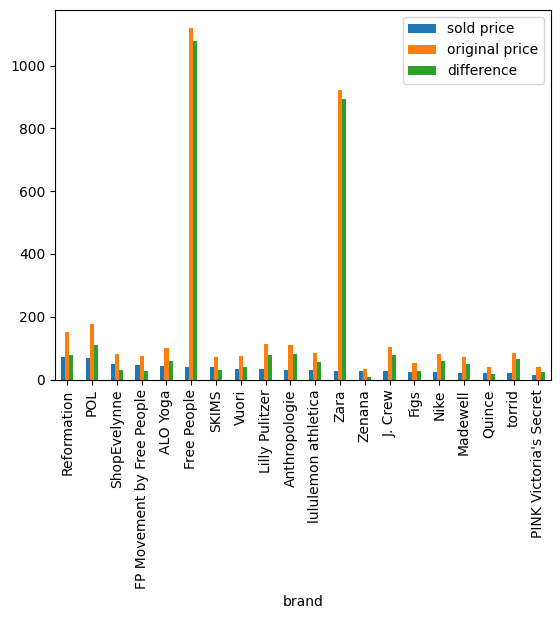

In [26]:
brand_avg_prices.plot(kind='bar')

#### Removing Outliers

There seem to be some outliers in the *original price* column, specifically for the brand *Zara*. This could be due to users inflating the listed original price for an item.

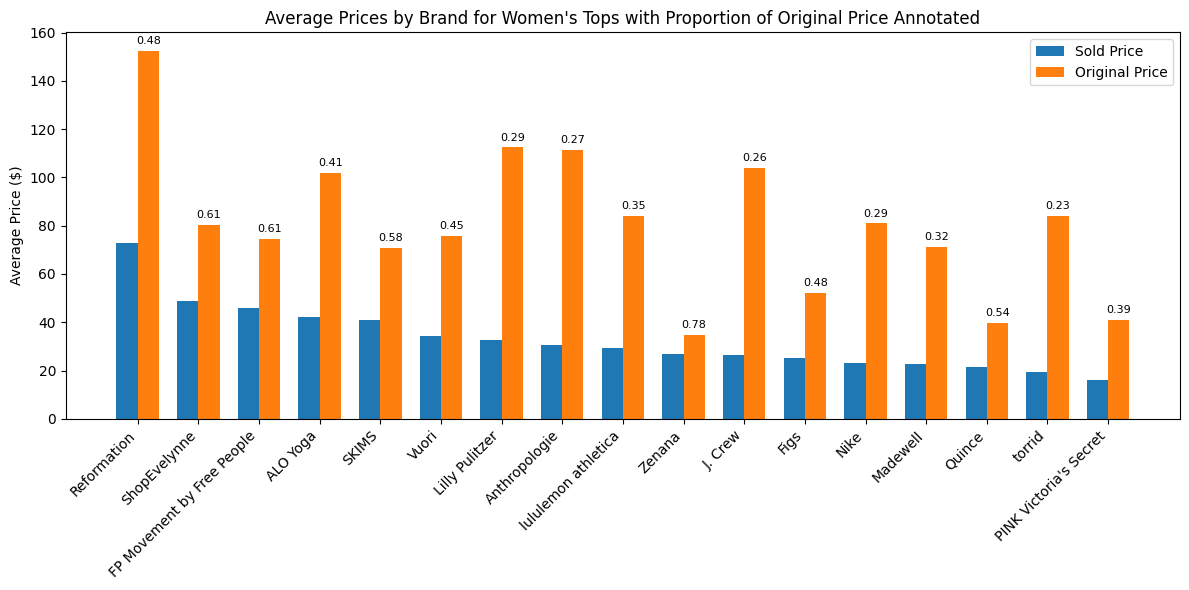

In [29]:
# remove outliers based on 'original price'
filtered_df = remove_outliers_iqr(brand_avg_prices, 'original price')

fig, ax = plt.subplots(figsize=(12, 6))
bar_width = 0.35
index = np.arange(len(filtered_df))

sold_bars = ax.bar(index, filtered_df['sold price'], bar_width, label='Sold Price')
orig_bars = ax.bar(index + bar_width, filtered_df['original price'], bar_width, label='Original Price')

# annotate the proportion of the sale cost to original cost
for i, brand in enumerate(filtered_df.index):
    sold = filtered_df.loc[brand, 'sold price']
    orig = filtered_df.loc[brand, 'original price']
    proportion = sold/orig
    ax.text(i + bar_width, orig + 2, f'{proportion:.2f}', ha='center', va='bottom', fontsize=8, color='black')

ax.set_ylabel('Average Price ($)')
ax.set_title("Average Prices by Brand for Women's Tops with Proportion of Original Price Annotated")
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(filtered_df.index, rotation=45, ha='right')
ax.legend()
plt.tight_layout()
plt.show()
